In [52]:
! nvidia-smi

Mon Feb  6 04:32:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.94       Driver Version: 516.94       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| 50%   54C    P8    11W / 350W |  24134MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ... WDDM  | 00000000:08:00.0  On |                  N/A |
|  0%   

In [53]:
from sklearn.exceptions import UndefinedMetricWarning

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [54]:
import torch
import torchvision
import torchvision.transforms as transforms

In [55]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [56]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform_train = transforms.Compose(
    [transforms.Resize((230,230)),
        transforms.RandomRotation(30,),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ])

transform = transforms.Compose(
    [transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ])

batch_size = 128

In [57]:
torchvision.datasets

<module 'torchvision.datasets' from 'C:\\Users\\posso\\miniconda3\\envs\\GIM\\lib\\site-packages\\torchvision\\datasets\\__init__.py'>

In [58]:
trainset = torchvision.datasets.Flowers102(root='./data', split='train', download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1)

valset = torchvision.datasets.Flowers102(root='./data', split='val', download=True, transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=1)

testset = torchvision.datasets.Flowers102(root='./data', split='test', download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=1)

#classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [59]:
trainset.__len__(), valset.__len__(), testset.__len__()

(1020, 1020, 6149)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


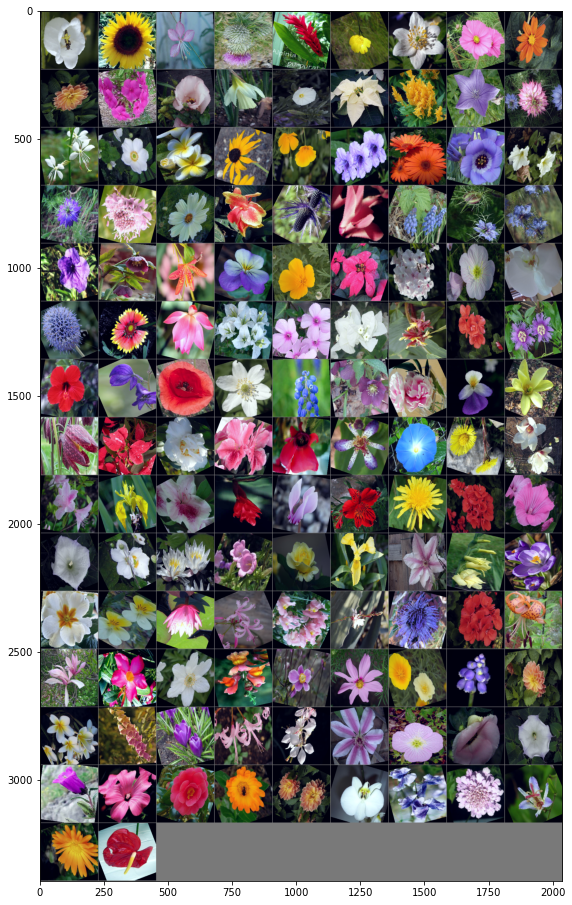

In [60]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img*torch.tensor([0.267, 0.256, 0.276]).mean() + torch.tensor([0.507, 0.487, 0.441]).mean()     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(16,16))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
nrow = 9
imshow(torchvision.utils.make_grid(images, nrow = nrow))

In [61]:
# print labels
for i in range(batch_size//nrow + 1 if batch_size % nrow else 0):
  print(' '.join(f'{labels[i*nrow+j]:<3}' for j in range(min(batch_size - i*nrow, nrow))))

2   53  56  13  23  47  68  33  58 
59  31  44  41  63  43  26  18  32 
56  61  80  62  64  97  40  44  50 
32  21  33  89  34  87  24  32  32 
97  39  101 51  64  43  31  0   6  
9   99  77  94  31  94  60  57  76 
82  8   25  68  24  39  30  51  86 
22  43  95  71  87  78  75  11  86 
71  14  71  23  87  17  49  57  85 
74  61  72  2   73  14  81  42  66 
52  51  72  36  10  56  28  57  5  
86  84  68  10  61  33  64  24  59 
80  93  66  36  56  81  0   44  74 
2   85  95  4   59  6   3   21  78 
4   79 


In [62]:
import torch.nn as nn
import torch.nn.functional as F

#pretrain_weight = torchvision.models.EfficientNet_V2_S_Weights.IMAGENET1K_V1
#net = torchvision.models.efficientnet_v2_s(weights = pretrain_weight)
#net.classifier[1] = nn.Linear(1280, 102)
#net = net.to(device)

model_ft = torchvision.models.resnext50_32x4d(pretrained=True)
num_ftrs = model_ft.fc.in_features
half_in_size = round(num_ftrs/2)
layer_width = 102
Num_class=102

Multilayer_fc = nn.Sequential(
            nn.Linear(num_ftrs, layer_width*2),
            nn.ReLU(inplace=True),
            nn.Linear(layer_width*2, layer_width*2),
            nn.ReLU(inplace=True),
            nn.Linear(layer_width*2, Num_class)
        )

model_ft.fc = Multilayer_fc

net = model_ft.to(device)

In [63]:
#from torchsummary import summary
#summary(net, (3, 100, 100), batch_size = 32)
from torchinfo import summary as summary_info
summary_info(net, input_size = (128, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   --                        --
├─Conv2d: 1-1                            [128, 64, 112, 112]       9,408
├─BatchNorm2d: 1-2                       [128, 64, 112, 112]       128
├─ReLU: 1-3                              [128, 64, 112, 112]       --
├─MaxPool2d: 1-4                         [128, 64, 56, 56]         --
├─Sequential: 1-5                        [128, 256, 56, 56]        --
│    └─Bottleneck: 2-1                   [128, 256, 56, 56]        --
│    │    └─Conv2d: 3-1                  [128, 128, 56, 56]        8,192
│    │    └─BatchNorm2d: 3-2             [128, 128, 56, 56]        256
│    │    └─ReLU: 3-3                    [128, 128, 56, 56]        --
│    │    └─Conv2d: 3-4                  [128, 128, 56, 56]        4,608
│    │    └─BatchNorm2d: 3-5             [128, 128, 56, 56]        256
│    │    └─ReLU: 3-6                    [128, 128, 56, 56]        --
│  

In [64]:
import torch.optim as optim
from torch.optim import lr_scheduler

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [65]:
from sklearn.metrics import classification_report
from tqdm.notebook import tqdm


epochs = 30

history_train = {'loss':np.zeros(epochs), 'acc':np.zeros(epochs), 'f1-score':np.zeros(epochs)}
history_val = {'loss':np.zeros(epochs), 'acc':np.zeros(epochs), 'f1-score':np.zeros(epochs)}
min_val_loss = 1e10
PATH = './Flowers102-resnext50.pth'

for epoch in range(epochs):  # loop over the dataset multiple times
    
    print(f'epoch {epoch + 1} \nTraining ...')
    net.train()
    y_predict = list()
    y_labels = list()
    training_loss = 0.0
    n = 0
    with torch.set_grad_enabled(True):
        for data in tqdm(trainloader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # aggregate statistics
        training_loss += loss.item()
        n+=1

        y_labels += list(labels.cpu().numpy())
        y_predict += list(outputs.argmax(dim=1).cpu().numpy())
    scheduler.step()

    # print statistics
    report = classification_report(y_labels, y_predict, digits = 4, output_dict = True)
    acc = report["accuracy"]
    f1 = report["weighted avg"]["f1-score"]
    support = report["weighted avg"]["support"]
    training_loss /= n
    print(f"training loss: {training_loss:.4}, acc: {acc*100:.4}%, f1-score: {f1*100:.4}%, support: {support}" )
    history_train['loss'][epoch] = training_loss
    history_train['acc'][epoch] = acc
    history_train['f1-score'][epoch] = f1

    print('validating ...')
    net.eval()
    
    optimizer.zero_grad()
    
    y_predict = list()
    y_labels = list()
    validation_loss = 0.0
    n = 0
    with torch.no_grad():
        for data in tqdm(valloader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()

            y_labels += list(labels.cpu().numpy())
            y_predict += list(outputs.argmax(dim=1).cpu().numpy())
            n+=1

    # print statistics
    report = classification_report(y_labels, y_predict, digits = 4, output_dict = True)
    acc = report["accuracy"]
    f1 = report["weighted avg"]["f1-score"]
    support = report["weighted avg"]["support"]
    validation_loss /= n
    print(f"validation loss: {validation_loss:.4}, acc: {acc*100:.4}%, f1-score: {f1*100:.4}%, support: {support}" )
    history_val['loss'][epoch] = validation_loss
    history_val['acc'][epoch] = acc
    history_val['f1-score'][epoch] = f1
    
    #save min validation loss
    if validation_loss < min_val_loss:
        torch.save(net.state_dict(), PATH)
        min_val_loss = validation_loss     
    
print('Finished Training')

epoch 1 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 4.622, acc: 0.0%, f1-score: 0.0%, support: 124.0
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 4.618, acc: 1.569%, f1-score: 0.1759%, support: 1020
epoch 2 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 4.597, acc: 6.452%, f1-score: 3.065%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 4.6, acc: 3.333%, f1-score: 1.07%, support: 1020
epoch 3 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 4.569, acc: 12.1%, f1-score: 6.444%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 4.575, acc: 6.569%, f1-score: 2.901%, support: 1020
epoch 4 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 4.528, acc: 4.839%, f1-score: 3.588%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 4.531, acc: 6.667%, f1-score: 3.549%, support: 1020
epoch 5 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 4.443, acc: 15.32%, f1-score: 12.68%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 4.458, acc: 8.137%, f1-score: 5.443%, support: 1020
epoch 6 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 4.332, acc: 16.13%, f1-score: 11.82%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 4.336, acc: 9.02%, f1-score: 5.864%, support: 1020
epoch 7 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 4.089, acc: 20.97%, f1-score: 17.67%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 4.138, acc: 9.412%, f1-score: 7.033%, support: 1020
epoch 8 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 4.1, acc: 20.16%, f1-score: 18.76%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 4.12, acc: 12.94%, f1-score: 10.72%, support: 1020
epoch 9 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 4.025, acc: 27.42%, f1-score: 24.22%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 4.097, acc: 16.18%, f1-score: 13.54%, support: 1020
epoch 10 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 4.02, acc: 21.77%, f1-score: 16.66%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 4.068, acc: 17.55%, f1-score: 14.51%, support: 1020
epoch 11 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 3.985, acc: 25.81%, f1-score: 21.44%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 4.038, acc: 18.92%, f1-score: 15.21%, support: 1020
epoch 12 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 3.929, acc: 30.65%, f1-score: 26.5%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 4.007, acc: 20.29%, f1-score: 16.54%, support: 1020
epoch 13 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 4.052, acc: 15.32%, f1-score: 13.94%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 3.97, acc: 20.59%, f1-score: 16.64%, support: 1020
epoch 14 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 3.78, acc: 34.68%, f1-score: 27.92%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 3.937, acc: 21.27%, f1-score: 17.26%, support: 1020
epoch 15 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 3.86, acc: 30.65%, f1-score: 27.56%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 3.933, acc: 21.67%, f1-score: 17.83%, support: 1020
epoch 16 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 3.967, acc: 17.74%, f1-score: 12.01%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 3.931, acc: 21.67%, f1-score: 17.71%, support: 1020
epoch 17 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 3.896, acc: 25.0%, f1-score: 19.77%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 3.929, acc: 21.86%, f1-score: 18.03%, support: 1020
epoch 18 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 3.726, acc: 37.1%, f1-score: 31.22%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 3.927, acc: 22.55%, f1-score: 18.96%, support: 1020
epoch 19 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 3.808, acc: 34.68%, f1-score: 31.84%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 3.925, acc: 22.45%, f1-score: 18.81%, support: 1020
epoch 20 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 3.903, acc: 22.58%, f1-score: 18.72%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 3.917, acc: 22.16%, f1-score: 18.25%, support: 1020
epoch 21 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 3.875, acc: 25.0%, f1-score: 19.74%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 3.915, acc: 22.45%, f1-score: 18.47%, support: 1020
epoch 22 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 3.845, acc: 31.45%, f1-score: 27.34%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 3.915, acc: 22.55%, f1-score: 18.72%, support: 1020
epoch 23 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 3.869, acc: 28.23%, f1-score: 25.61%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 3.915, acc: 22.65%, f1-score: 18.92%, support: 1020
epoch 24 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 3.795, acc: 29.03%, f1-score: 23.13%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 3.914, acc: 22.35%, f1-score: 18.48%, support: 1020
epoch 25 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 3.973, acc: 21.77%, f1-score: 19.77%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 3.914, acc: 22.45%, f1-score: 18.44%, support: 1020
epoch 26 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 3.872, acc: 29.84%, f1-score: 24.73%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 3.911, acc: 22.65%, f1-score: 18.62%, support: 1020
epoch 27 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 3.859, acc: 29.03%, f1-score: 26.81%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 3.911, acc: 22.75%, f1-score: 18.79%, support: 1020
epoch 28 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 3.813, acc: 27.42%, f1-score: 22.09%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 3.911, acc: 22.84%, f1-score: 18.93%, support: 1020
epoch 29 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 3.835, acc: 29.03%, f1-score: 24.66%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 3.912, acc: 22.65%, f1-score: 18.82%, support: 1020
epoch 30 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 3.843, acc: 34.68%, f1-score: 34.38%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 3.911, acc: 22.35%, f1-score: 18.48%, support: 1020
Finished Training


In [67]:
import torch.optim as optim
from torch.optim import lr_scheduler

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [68]:
from sklearn.metrics import classification_report
from tqdm.notebook import tqdm


epochs = 10

history_train = {'loss':np.zeros(epochs), 'acc':np.zeros(epochs), 'f1-score':np.zeros(epochs)}
history_val = {'loss':np.zeros(epochs), 'acc':np.zeros(epochs), 'f1-score':np.zeros(epochs)}
min_val_loss = 1e10
PATH = './Flowers102-resnext50.pth'

for epoch in range(epochs):  # loop over the dataset multiple times
    
    print(f'epoch {epoch + 1} \nTraining ...')
    net.train()
    y_predict = list()
    y_labels = list()
    training_loss = 0.0
    n = 0
    with torch.set_grad_enabled(True):
        for data in tqdm(trainloader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # aggregate statistics
        training_loss += loss.item()
        n+=1

        y_labels += list(labels.cpu().numpy())
        y_predict += list(outputs.argmax(dim=1).cpu().numpy())
    scheduler.step()

    # print statistics
    report = classification_report(y_labels, y_predict, digits = 4, output_dict = True)
    acc = report["accuracy"]
    f1 = report["weighted avg"]["f1-score"]
    support = report["weighted avg"]["support"]
    training_loss /= n
    print(f"training loss: {training_loss:.4}, acc: {acc*100:.4}%, f1-score: {f1*100:.4}%, support: {support}" )
    history_train['loss'][epoch] = training_loss
    history_train['acc'][epoch] = acc
    history_train['f1-score'][epoch] = f1

    print('validating ...')
    net.eval()
    
    optimizer.zero_grad()
    
    y_predict = list()
    y_labels = list()
    validation_loss = 0.0
    n = 0
    with torch.no_grad():
        for data in tqdm(valloader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()

            y_labels += list(labels.cpu().numpy())
            y_predict += list(outputs.argmax(dim=1).cpu().numpy())
            n+=1

    # print statistics
    report = classification_report(y_labels, y_predict, digits = 4, output_dict = True)
    acc = report["accuracy"]
    f1 = report["weighted avg"]["f1-score"]
    support = report["weighted avg"]["support"]
    validation_loss /= n
    print(f"validation loss: {validation_loss:.4}, acc: {acc*100:.4}%, f1-score: {f1*100:.4}%, support: {support}" )
    history_val['loss'][epoch] = validation_loss
    history_val['acc'][epoch] = acc
    history_val['f1-score'][epoch] = f1
    
    #save min validation loss
    if validation_loss < min_val_loss:
        torch.save(net.state_dict(), PATH)
        min_val_loss = validation_loss     
    
print('Finished Training')

epoch 1 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 3.767, acc: 30.65%, f1-score: 26.69%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 3.752, acc: 25.0%, f1-score: 19.87%, support: 1020
epoch 2 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 3.42, acc: 39.52%, f1-score: 35.81%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 3.454, acc: 30.2%, f1-score: 23.05%, support: 1020
epoch 3 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 3.002, acc: 44.35%, f1-score: 39.31%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 3.091, acc: 36.76%, f1-score: 29.73%, support: 1020
epoch 4 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 2.57, acc: 54.03%, f1-score: 53.74%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 2.705, acc: 46.76%, f1-score: 40.07%, support: 1020
epoch 5 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 2.136, acc: 60.48%, f1-score: 55.33%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 2.302, acc: 57.75%, f1-score: 51.68%, support: 1020
epoch 6 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 1.727, acc: 69.35%, f1-score: 67.02%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 1.907, acc: 64.61%, f1-score: 59.92%, support: 1020
epoch 7 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 1.426, acc: 73.39%, f1-score: 70.81%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 1.574, acc: 69.61%, f1-score: 65.9%, support: 1020
epoch 8 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 1.148, acc: 83.06%, f1-score: 82.56%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 1.501, acc: 71.67%, f1-score: 68.33%, support: 1020
epoch 9 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 1.11, acc: 87.1%, f1-score: 85.97%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 1.453, acc: 73.04%, f1-score: 70.21%, support: 1020
epoch 10 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 1.034, acc: 83.87%, f1-score: 82.2%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 1.417, acc: 73.63%, f1-score: 70.78%, support: 1020
Finished Training


In [69]:
import torch.optim as optim
from torch.optim import lr_scheduler

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [70]:
from sklearn.metrics import classification_report
from tqdm.notebook import tqdm


epochs = 30

history_train = {'loss':np.zeros(epochs), 'acc':np.zeros(epochs), 'f1-score':np.zeros(epochs)}
history_val = {'loss':np.zeros(epochs), 'acc':np.zeros(epochs), 'f1-score':np.zeros(epochs)}
min_val_loss = 1e10
PATH = './Flowers102-resnext50.pth'

for epoch in range(epochs):  # loop over the dataset multiple times
    
    print(f'epoch {epoch + 1} \nTraining ...')
    net.train()
    y_predict = list()
    y_labels = list()
    training_loss = 0.0
    n = 0
    with torch.set_grad_enabled(True):
        for data in tqdm(trainloader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # aggregate statistics
        training_loss += loss.item()
        n+=1

        y_labels += list(labels.cpu().numpy())
        y_predict += list(outputs.argmax(dim=1).cpu().numpy())
    scheduler.step()

    # print statistics
    report = classification_report(y_labels, y_predict, digits = 4, output_dict = True)
    acc = report["accuracy"]
    f1 = report["weighted avg"]["f1-score"]
    support = report["weighted avg"]["support"]
    training_loss /= n
    print(f"training loss: {training_loss:.4}, acc: {acc*100:.4}%, f1-score: {f1*100:.4}%, support: {support}" )
    history_train['loss'][epoch] = training_loss
    history_train['acc'][epoch] = acc
    history_train['f1-score'][epoch] = f1

    print('validating ...')
    net.eval()
    
    optimizer.zero_grad()
    
    y_predict = list()
    y_labels = list()
    validation_loss = 0.0
    n = 0
    with torch.no_grad():
        for data in tqdm(valloader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()

            y_labels += list(labels.cpu().numpy())
            y_predict += list(outputs.argmax(dim=1).cpu().numpy())
            n+=1

    # print statistics
    report = classification_report(y_labels, y_predict, digits = 4, output_dict = True)
    acc = report["accuracy"]
    f1 = report["weighted avg"]["f1-score"]
    support = report["weighted avg"]["support"]
    validation_loss /= n
    print(f"validation loss: {validation_loss:.4}, acc: {acc*100:.4}%, f1-score: {f1*100:.4}%, support: {support}" )
    history_val['loss'][epoch] = validation_loss
    history_val['acc'][epoch] = acc
    history_val['f1-score'][epoch] = f1
    
    #save min validation loss
    if validation_loss < min_val_loss:
        torch.save(net.state_dict(), PATH)
        min_val_loss = validation_loss     
    
print('Finished Training')

epoch 1 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 1.091, acc: 86.29%, f1-score: 86.32%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 1.41, acc: 73.63%, f1-score: 70.92%, support: 1020
epoch 2 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 0.8837, acc: 89.52%, f1-score: 88.93%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 1.386, acc: 73.82%, f1-score: 71.08%, support: 1020
epoch 3 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 1.067, acc: 85.48%, f1-score: 85.16%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 1.363, acc: 74.31%, f1-score: 71.74%, support: 1020
epoch 4 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 0.9947, acc: 89.52%, f1-score: 88.01%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 1.333, acc: 75.2%, f1-score: 72.9%, support: 1020
epoch 5 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 0.826, acc: 91.94%, f1-score: 92.02%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 1.311, acc: 75.49%, f1-score: 73.34%, support: 1020
epoch 6 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 0.9453, acc: 88.71%, f1-score: 88.44%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 1.28, acc: 75.59%, f1-score: 73.61%, support: 1020
epoch 7 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 0.9134, acc: 89.52%, f1-score: 88.63%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 1.248, acc: 76.67%, f1-score: 74.99%, support: 1020
epoch 8 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 0.8571, acc: 88.71%, f1-score: 89.81%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 1.245, acc: 76.57%, f1-score: 74.89%, support: 1020
epoch 9 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 0.9434, acc: 87.9%, f1-score: 88.64%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 1.242, acc: 76.67%, f1-score: 75.13%, support: 1020
epoch 10 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 0.8253, acc: 88.71%, f1-score: 88.74%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 1.236, acc: 76.86%, f1-score: 75.36%, support: 1020
epoch 11 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 0.8266, acc: 90.32%, f1-score: 88.76%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 1.236, acc: 76.86%, f1-score: 75.42%, support: 1020
epoch 12 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 0.7702, acc: 94.35%, f1-score: 92.62%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 1.233, acc: 76.86%, f1-score: 75.43%, support: 1020
epoch 13 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 0.8239, acc: 92.74%, f1-score: 93.09%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 1.23, acc: 76.76%, f1-score: 75.35%, support: 1020
epoch 14 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 0.8603, acc: 91.13%, f1-score: 90.46%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 1.228, acc: 76.96%, f1-score: 75.61%, support: 1020
epoch 15 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 0.7735, acc: 93.55%, f1-score: 93.01%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 1.226, acc: 76.86%, f1-score: 75.48%, support: 1020
epoch 16 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 0.9198, acc: 88.71%, f1-score: 89.63%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 1.227, acc: 76.86%, f1-score: 75.44%, support: 1020
epoch 17 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 0.8194, acc: 91.13%, f1-score: 91.02%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 1.228, acc: 76.67%, f1-score: 75.17%, support: 1020
epoch 18 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 0.8432, acc: 91.13%, f1-score: 91.53%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 1.226, acc: 76.96%, f1-score: 75.52%, support: 1020
epoch 19 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 0.8071, acc: 91.94%, f1-score: 91.45%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 1.225, acc: 77.16%, f1-score: 75.8%, support: 1020
epoch 20 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 0.8777, acc: 89.52%, f1-score: 90.36%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 1.228, acc: 76.67%, f1-score: 75.23%, support: 1020
epoch 21 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 0.8348, acc: 87.9%, f1-score: 87.61%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 1.229, acc: 76.76%, f1-score: 75.25%, support: 1020
epoch 22 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 0.7694, acc: 93.55%, f1-score: 93.2%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 1.228, acc: 76.57%, f1-score: 75.08%, support: 1020
epoch 23 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 0.7547, acc: 92.74%, f1-score: 91.29%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 1.226, acc: 76.96%, f1-score: 75.52%, support: 1020
epoch 24 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 0.7731, acc: 90.32%, f1-score: 89.57%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 1.226, acc: 76.76%, f1-score: 75.29%, support: 1020
epoch 25 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 0.7819, acc: 95.16%, f1-score: 95.22%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 1.227, acc: 76.76%, f1-score: 75.32%, support: 1020
epoch 26 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 0.8164, acc: 90.32%, f1-score: 90.35%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 1.227, acc: 76.76%, f1-score: 75.32%, support: 1020
epoch 27 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 0.7987, acc: 91.94%, f1-score: 91.04%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 1.225, acc: 77.06%, f1-score: 75.69%, support: 1020
epoch 28 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 0.9457, acc: 88.71%, f1-score: 89.27%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 1.226, acc: 77.16%, f1-score: 75.76%, support: 1020
epoch 29 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 0.9495, acc: 88.71%, f1-score: 89.25%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 1.226, acc: 77.06%, f1-score: 75.62%, support: 1020
epoch 30 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 0.8235, acc: 91.13%, f1-score: 90.19%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 1.227, acc: 76.96%, f1-score: 75.54%, support: 1020
Finished Training


In [72]:
import torch.optim as optim
from torch.optim import lr_scheduler

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [73]:
from sklearn.metrics import classification_report
from tqdm.notebook import tqdm


epochs = 10

history_train = {'loss':np.zeros(epochs), 'acc':np.zeros(epochs), 'f1-score':np.zeros(epochs)}
history_val = {'loss':np.zeros(epochs), 'acc':np.zeros(epochs), 'f1-score':np.zeros(epochs)}
min_val_loss = 1e10
PATH = './Flowers102-resnext50.pth'

for epoch in range(epochs):  # loop over the dataset multiple times
    
    print(f'epoch {epoch + 1} \nTraining ...')
    net.train()
    y_predict = list()
    y_labels = list()
    training_loss = 0.0
    n = 0
    with torch.set_grad_enabled(True):
        for data in tqdm(trainloader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # aggregate statistics
        training_loss += loss.item()
        n+=1

        y_labels += list(labels.cpu().numpy())
        y_predict += list(outputs.argmax(dim=1).cpu().numpy())
    scheduler.step()

    # print statistics
    report = classification_report(y_labels, y_predict, digits = 4, output_dict = True)
    acc = report["accuracy"]
    f1 = report["weighted avg"]["f1-score"]
    support = report["weighted avg"]["support"]
    training_loss /= n
    print(f"training loss: {training_loss:.4}, acc: {acc*100:.4}%, f1-score: {f1*100:.4}%, support: {support}" )
    history_train['loss'][epoch] = training_loss
    history_train['acc'][epoch] = acc
    history_train['f1-score'][epoch] = f1

    print('validating ...')
    net.eval()
    
    optimizer.zero_grad()
    
    y_predict = list()
    y_labels = list()
    validation_loss = 0.0
    n = 0
    with torch.no_grad():
        for data in tqdm(valloader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()

            y_labels += list(labels.cpu().numpy())
            y_predict += list(outputs.argmax(dim=1).cpu().numpy())
            n+=1

    # print statistics
    report = classification_report(y_labels, y_predict, digits = 4, output_dict = True)
    acc = report["accuracy"]
    f1 = report["weighted avg"]["f1-score"]
    support = report["weighted avg"]["support"]
    validation_loss /= n
    print(f"validation loss: {validation_loss:.4}, acc: {acc*100:.4}%, f1-score: {f1*100:.4}%, support: {support}" )
    history_val['loss'][epoch] = validation_loss
    history_val['acc'][epoch] = acc
    history_val['f1-score'][epoch] = f1
    
    #save min validation loss
    if validation_loss < min_val_loss:
        torch.save(net.state_dict(), PATH)
        min_val_loss = validation_loss     
    
print('Finished Training')

epoch 1 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 0.792, acc: 93.55%, f1-score: 93.76%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 1.215, acc: 77.25%, f1-score: 75.79%, support: 1020
epoch 2 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 0.8873, acc: 91.13%, f1-score: 91.45%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 1.203, acc: 77.45%, f1-score: 76.14%, support: 1020
epoch 3 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 0.7314, acc: 90.32%, f1-score: 89.19%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 1.179, acc: 78.33%, f1-score: 77.0%, support: 1020
epoch 4 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 0.729, acc: 92.74%, f1-score: 93.83%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 1.152, acc: 78.73%, f1-score: 77.39%, support: 1020
epoch 5 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 0.7576, acc: 92.74%, f1-score: 93.49%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 1.131, acc: 79.12%, f1-score: 77.91%, support: 1020
epoch 6 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 0.6766, acc: 90.32%, f1-score: 91.15%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 1.11, acc: 78.82%, f1-score: 77.61%, support: 1020
epoch 7 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 0.666, acc: 90.32%, f1-score: 91.64%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 1.09, acc: 79.02%, f1-score: 77.68%, support: 1020
epoch 8 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 0.6456, acc: 92.74%, f1-score: 93.17%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 1.088, acc: 79.12%, f1-score: 77.78%, support: 1020
epoch 9 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 0.6221, acc: 95.16%, f1-score: 95.08%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 1.087, acc: 78.92%, f1-score: 77.74%, support: 1020
epoch 10 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 0.5927, acc: 96.77%, f1-score: 97.18%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 1.084, acc: 79.02%, f1-score: 77.69%, support: 1020
Finished Training


In [74]:
import torch.optim as optim
from torch.optim import lr_scheduler

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [75]:
from sklearn.metrics import classification_report
from tqdm.notebook import tqdm


epochs = 5

history_train = {'loss':np.zeros(epochs), 'acc':np.zeros(epochs), 'f1-score':np.zeros(epochs)}
history_val = {'loss':np.zeros(epochs), 'acc':np.zeros(epochs), 'f1-score':np.zeros(epochs)}
min_val_loss = 1e10
PATH = './Flowers102-resnext50.pth'

for epoch in range(epochs):  # loop over the dataset multiple times
    
    print(f'epoch {epoch + 1} \nTraining ...')
    net.train()
    y_predict = list()
    y_labels = list()
    training_loss = 0.0
    n = 0
    with torch.set_grad_enabled(True):
        for data in tqdm(trainloader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # aggregate statistics
        training_loss += loss.item()
        n+=1

        y_labels += list(labels.cpu().numpy())
        y_predict += list(outputs.argmax(dim=1).cpu().numpy())
    scheduler.step()

    # print statistics
    report = classification_report(y_labels, y_predict, digits = 4, output_dict = True)
    acc = report["accuracy"]
    f1 = report["weighted avg"]["f1-score"]
    support = report["weighted avg"]["support"]
    training_loss /= n
    print(f"training loss: {training_loss:.4}, acc: {acc*100:.4}%, f1-score: {f1*100:.4}%, support: {support}" )
    history_train['loss'][epoch] = training_loss
    history_train['acc'][epoch] = acc
    history_train['f1-score'][epoch] = f1

    print('validating ...')
    net.eval()
    
    optimizer.zero_grad()
    
    y_predict = list()
    y_labels = list()
    validation_loss = 0.0
    n = 0
    with torch.no_grad():
        for data in tqdm(valloader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()

            y_labels += list(labels.cpu().numpy())
            y_predict += list(outputs.argmax(dim=1).cpu().numpy())
            n+=1

    # print statistics
    report = classification_report(y_labels, y_predict, digits = 4, output_dict = True)
    acc = report["accuracy"]
    f1 = report["weighted avg"]["f1-score"]
    support = report["weighted avg"]["support"]
    validation_loss /= n
    print(f"validation loss: {validation_loss:.4}, acc: {acc*100:.4}%, f1-score: {f1*100:.4}%, support: {support}" )
    history_val['loss'][epoch] = validation_loss
    history_val['acc'][epoch] = acc
    history_val['f1-score'][epoch] = f1
    
    #save min validation loss
    if validation_loss < min_val_loss:
        torch.save(net.state_dict(), PATH)
        min_val_loss = validation_loss     
    
print('Finished Training')

epoch 1 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 0.5881, acc: 94.35%, f1-score: 95.01%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 1.076, acc: 79.41%, f1-score: 78.18%, support: 1020
epoch 2 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 0.7878, acc: 91.13%, f1-score: 91.21%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 1.061, acc: 79.8%, f1-score: 78.66%, support: 1020
epoch 3 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 0.6755, acc: 91.94%, f1-score: 93.3%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 1.041, acc: 80.1%, f1-score: 78.95%, support: 1020
epoch 4 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 0.5248, acc: 99.19%, f1-score: 98.92%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 1.021, acc: 80.2%, f1-score: 79.1%, support: 1020
epoch 5 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 0.5267, acc: 97.58%, f1-score: 97.28%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 1.004, acc: 81.08%, f1-score: 80.06%, support: 1020
Finished Training


In [76]:
import torch.optim as optim
from torch.optim import lr_scheduler

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [77]:
from sklearn.metrics import classification_report
from tqdm.notebook import tqdm


epochs = 5

history_train = {'loss':np.zeros(epochs), 'acc':np.zeros(epochs), 'f1-score':np.zeros(epochs)}
history_val = {'loss':np.zeros(epochs), 'acc':np.zeros(epochs), 'f1-score':np.zeros(epochs)}
min_val_loss = 1e10
PATH = './Flowers102-resnext50.pth'

for epoch in range(epochs):  # loop over the dataset multiple times
    
    print(f'epoch {epoch + 1} \nTraining ...')
    net.train()
    y_predict = list()
    y_labels = list()
    training_loss = 0.0
    n = 0
    with torch.set_grad_enabled(True):
        for data in tqdm(trainloader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # aggregate statistics
        training_loss += loss.item()
        n+=1

        y_labels += list(labels.cpu().numpy())
        y_predict += list(outputs.argmax(dim=1).cpu().numpy())
    scheduler.step()

    # print statistics
    report = classification_report(y_labels, y_predict, digits = 4, output_dict = True)
    acc = report["accuracy"]
    f1 = report["weighted avg"]["f1-score"]
    support = report["weighted avg"]["support"]
    training_loss /= n
    print(f"training loss: {training_loss:.4}, acc: {acc*100:.4}%, f1-score: {f1*100:.4}%, support: {support}" )
    history_train['loss'][epoch] = training_loss
    history_train['acc'][epoch] = acc
    history_train['f1-score'][epoch] = f1

    print('validating ...')
    net.eval()
    
    optimizer.zero_grad()
    
    y_predict = list()
    y_labels = list()
    validation_loss = 0.0
    n = 0
    with torch.no_grad():
        for data in tqdm(valloader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()

            y_labels += list(labels.cpu().numpy())
            y_predict += list(outputs.argmax(dim=1).cpu().numpy())
            n+=1

    # print statistics
    report = classification_report(y_labels, y_predict, digits = 4, output_dict = True)
    acc = report["accuracy"]
    f1 = report["weighted avg"]["f1-score"]
    support = report["weighted avg"]["support"]
    validation_loss /= n
    print(f"validation loss: {validation_loss:.4}, acc: {acc*100:.4}%, f1-score: {f1*100:.4}%, support: {support}" )
    history_val['loss'][epoch] = validation_loss
    history_val['acc'][epoch] = acc
    history_val['f1-score'][epoch] = f1
    
    #save min validation loss
    if validation_loss < min_val_loss:
        torch.save(net.state_dict(), PATH)
        min_val_loss = validation_loss     
    
print('Finished Training')

epoch 1 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 0.4896, acc: 95.97%, f1-score: 96.1%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 0.9984, acc: 80.59%, f1-score: 79.52%, support: 1020
epoch 2 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 0.5275, acc: 94.35%, f1-score: 93.63%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 0.981, acc: 80.98%, f1-score: 79.9%, support: 1020
epoch 3 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 0.5203, acc: 95.97%, f1-score: 96.21%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 0.9684, acc: 81.08%, f1-score: 79.9%, support: 1020
epoch 4 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 0.4402, acc: 97.58%, f1-score: 97.77%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 0.9568, acc: 80.98%, f1-score: 80.01%, support: 1020
epoch 5 
Training ...


  0%|          | 0/8 [00:00<?, ?it/s]

training loss: 0.4982, acc: 96.77%, f1-score: 97.31%, support: 124
validating ...


  0%|          | 0/8 [00:00<?, ?it/s]

validation loss: 0.9405, acc: 81.67%, f1-score: 80.73%, support: 1020
Finished Training


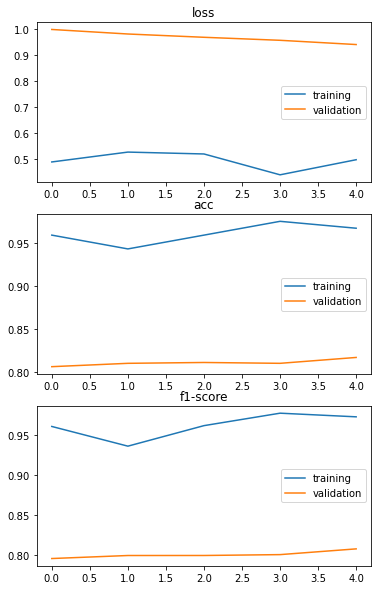

In [78]:
fig, axs = plt.subplots(3, figsize= (6,10))
# loss
axs[0].plot(history_train['loss'], label = 'training')
axs[0].plot(history_val['loss'], label = 'validation')
axs[0].set_title("loss")
axs[0].legend()
# acc
axs[1].plot(history_train['acc'], label = 'training')
axs[1].plot(history_val['acc'], label = 'validation')
axs[1].set_title("acc")
axs[1].legend()
# f1-score
axs[2].plot(history_train['f1-score'], label = 'training')
axs[2].plot(history_val['f1-score'], label = 'validation')
axs[2].set_title("f1-score")
axs[2].legend()
plt.show()

In [79]:
PATH = './Flowers102-resnext50.pth'
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [80]:
from sklearn.metrics import confusion_matrix

print('testing ...')
y_predict = list()
y_labels = list()
test_loss = 0.0
n = 0
with torch.no_grad():
    for data in tqdm(testloader):
        net.eval()
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        y_labels += list(labels.cpu().numpy())
        y_predict += list(outputs.argmax(dim=1).cpu().numpy())
        n+=1

    # print statistics
    test_loss /= n
    print(f"testing loss: {test_loss:.4}" )
    
    report = classification_report(y_labels, y_predict, digits = 4)
    M = confusion_matrix(y_labels, y_predict)
    print(report)
    #acc = report["accuracy"]
    #f1 = report["weighted avg"]["f1-score"]
    #support = report["weighted avg"]["support"]
    #test_loss /= n
    #print(f"validation loss: {test_loss:.4}, acc: {acc*100:.4}%, f1-score: {f1*100:.4}%, support: {support}" )

testing ...


  0%|          | 0/49 [00:00<?, ?it/s]

testing loss: 1.069
              precision    recall  f1-score   support

           0     0.4667    0.7000    0.5600        20
           1     0.9474    0.9000    0.9231        40
           2     0.5000    0.4500    0.4737        20
           3     0.4000    0.2778    0.3279        36
           4     0.9130    0.9333    0.9231        45
           5     1.0000    1.0000    1.0000        25
           6     0.3167    0.9500    0.4750        20
           7     0.9701    1.0000    0.9848        65
           8     0.5946    0.8462    0.6984        26
           9     0.9600    0.9600    0.9600        25
          10     0.8788    0.4328    0.5800        67
          11     0.9429    0.9851    0.9635        67
          12     0.8286    1.0000    0.9062        29
          13     0.9032    1.0000    0.9492        28
          14     0.6585    0.9310    0.7714        29
          15     0.5714    0.9524    0.7143        21
          16     0.9516    0.9077    0.9291        65
       

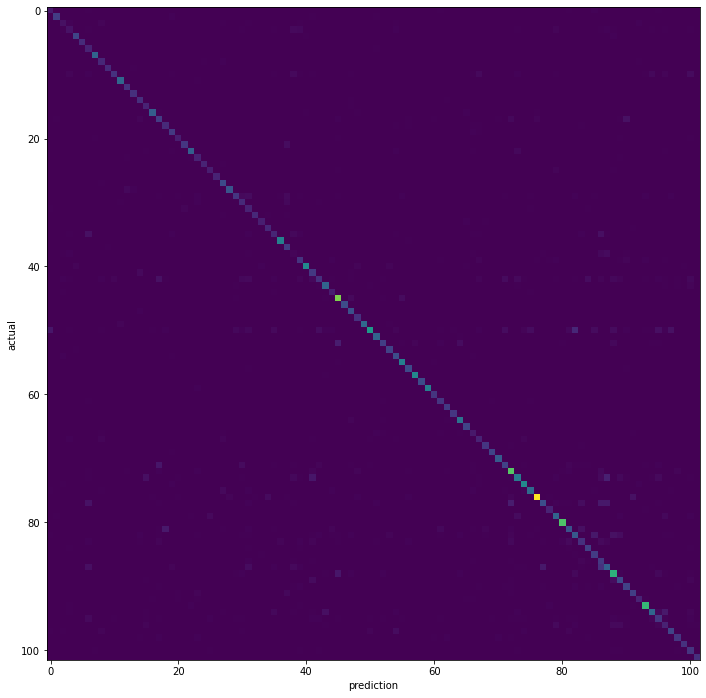

In [81]:
fig, ax = plt.subplots(figsize=(12,12))
im = ax.imshow(M)
ax.set_xlabel("prediction")
ax.set_ylabel("actual")
plt.show()

In [82]:
from sklearn.metrics import confusion_matrix

print('testing ...')
y_predict = list()
y_labels = list()
test_loss = 0.0
n = 0
with torch.no_grad():
    for data in tqdm(trainloader):
        net.eval()
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        y_labels += list(labels.cpu().numpy())
        y_predict += list(outputs.argmax(dim=1).cpu().numpy())
        n+=1

    # print statistics
    test_loss /= n
    print(f"testing loss: {test_loss:.4}" )
    
    report = classification_report(y_labels, y_predict, digits = 4)
    M = confusion_matrix(y_labels, y_predict)
    print(report)
    #acc = report["accuracy"]
    #f1 = report["weighted avg"]["f1-score"]
    #support = report["weighted avg"]["support"]
    #test_loss /= n
    #print(f"validation loss: {test_loss:.4}, acc: {acc*100:.4}%, f1-score: {f1*100:.4}%, support: {support}" )

testing ...


  0%|          | 0/8 [00:00<?, ?it/s]

testing loss: 0.4132
              precision    recall  f1-score   support

           0     0.9091    1.0000    0.9524        10
           1     1.0000    1.0000    1.0000        10
           2     1.0000    0.7000    0.8235        10
           3     0.8889    0.8000    0.8421        10
           4     1.0000    1.0000    1.0000        10
           5     1.0000    1.0000    1.0000        10
           6     1.0000    1.0000    1.0000        10
           7     1.0000    1.0000    1.0000        10
           8     0.9091    1.0000    0.9524        10
           9     1.0000    1.0000    1.0000        10
          10     1.0000    1.0000    1.0000        10
          11     1.0000    1.0000    1.0000        10
          12     1.0000    1.0000    1.0000        10
          13     1.0000    1.0000    1.0000        10
          14     1.0000    1.0000    1.0000        10
          15     1.0000    1.0000    1.0000        10
          16     1.0000    1.0000    1.0000        10
      

In [83]:
from sklearn.metrics import confusion_matrix

print('testing ...')
y_predict = list()
y_labels = list()
test_loss = 0.0
n = 0
with torch.no_grad():
    for data in tqdm(valloader):
        net.eval()
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        y_labels += list(labels.cpu().numpy())
        y_predict += list(outputs.argmax(dim=1).cpu().numpy())
        n+=1

    # print statistics
    test_loss /= n
    print(f"testing loss: {test_loss:.4}" )
    
    report = classification_report(y_labels, y_predict, digits = 4)
    M = confusion_matrix(y_labels, y_predict)
    print(report)
    #acc = report["accuracy"]
    #f1 = report["weighted avg"]["f1-score"]
    #support = report["weighted avg"]["support"]
    #test_loss /= n
    #print(f"validation loss: {test_loss:.4}, acc: {acc*100:.4}%, f1-score: {f1*100:.4}%, support: {support}" )

testing ...


  0%|          | 0/8 [00:00<?, ?it/s]

testing loss: 0.9405
              precision    recall  f1-score   support

           0     1.0000    0.8000    0.8889        10
           1     0.8000    0.8000    0.8000        10
           2     0.5000    0.1000    0.1667        10
           3     0.2727    0.3000    0.2857        10
           4     0.9091    1.0000    0.9524        10
           5     1.0000    1.0000    1.0000        10
           6     0.6154    0.8000    0.6957        10
           7     0.9091    1.0000    0.9524        10
           8     0.6667    1.0000    0.8000        10
           9     0.9091    1.0000    0.9524        10
          10     0.6667    0.4000    0.5000        10
          11     1.0000    0.9000    0.9474        10
          12     1.0000    1.0000    1.0000        10
          13     1.0000    1.0000    1.0000        10
          14     0.8333    1.0000    0.9091        10
          15     0.9091    1.0000    0.9524        10
          16     1.0000    1.0000    1.0000        10
      